## Analyzing LinkedIn Job Postings

&nbsp;

For this I will be using the “LinkedIn Job Postings (2023 - 2024)” dataset on Kaggle. The dataset contains 11 csv files that contain information about each job posting and information about the respective company.\
\
The main csv file, “postings.csv”, contains 123,850 observations and 31 attributes of which are job_id, company_name, title, description, max_salary, pay_period, location, company_id, views, and med_salary. “industries.csv” provides more information about the industry name for each job posting using its industry ID and contains the attributes industry_id and industry_name. Similarly, “skills.csv” provides more information about the respective skill_name for each skill_abr, “job_industries.csv” includes the industry_id for each job_id, and “job_skills.csv” contains the skill abbreviations (skill_abr) for each job_id. Finally, “salaries.csv” has details about the salary for each job posting containing salary_id, job_id, max_salary, med_salary, min_salary, pay_period, currency, and compensation_type. “benefits.csv” describes the type of benefits associated with each job_id and whether it was explicitly tagged or implied through the job text. The company related CSVs then include more information about the industries each company is in, the size of the company, its address, specialties, and employee and follower count.\
\
While well-structured, the data contained null values and required lots of pre-processing and some cleaning to remove unneccessary columns such as the job post’s job description and company url. Other pre-processing steps also included having to convert all salaries to annual salaries and converting them to USD. Other steps also included creating categorical labels for certain attributes using get_dummies(), and calculating the region for each job post based on its given location. With this analysis, it is possible to explore trends within the job market and what makes an applicant apply to one job versus one another. This would benefit not just applicants but companies themselves as they could use these results to tailor job postings to applicants better. It is also possible to examine how different industries and companies differ with their internship and job offerings and benefits.\
\
As for the tasks that I will be performing, I will be be performing 4 different tasks: Exploratory Data Analysis (EDA), Classification, Regression, and Outlier Detection.\
\
For EDA, I will be identifying trends in salary, location, and benefits. Additionally, I plan on identifying trends in what skills are the most in demand. Other possible questions to be answered could be which industries have the highest demand for jobs. Techniques I plan on utilizing are histograms, and box-plots, as well as correlation heat maps.\
\
For Classification, I will be classifying whether a job post will be in Texas using Random Forests, KNN, and Logistic Regression.\
\
Using regression techniques, namely linear regression, I will predict the normalized salary based on company employee count and company follower count.\
\
Lastly, outlier detection of normalized salaries will involve using statistical methods like IQR, Z Scores, and box plots to detect outliers in key variables such as views.

&nbsp;

## Pre-processing

&nbsp;

In [1209]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from wordcloud import WordCloud 
import seaborn as sns 

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from scipy import stats
from sklearn import tree


In [ ]:
# Read CSV data and convert into data frames

postings_df = pd.read_csv('/kaggle/input/linkedin-job-postings/job_postings.csv')

industry_mappings_df = pd.read_csv('/kaggle/input/linkedin-job-postings/maps/industries.csv')
skills_mappings_df = pd.read_csv('/kaggle/input/linkedin-job-postings/maps/skills.csv')

job_benefits_df = pd.read_csv('/kaggle/input/linkedin-job-postings/job_details/benefits.csv')
job_industries_df = pd.read_csv('/kaggle/input/linkedin-job-postings/job_details/job_industries.csv')
job_skills_df = pd.read_csv('/kaggle/input/linkedin-job-postings/job_details/job_skills.csv')
job_salaries_df = pd.read_csv('/kaggle/input/linkedin-job-postings/job_details/salaries.csv')

companies_df = pd.read_csv('/kaggle/input/linkedin-job-postings/company_details/companies.csv')
company_industries_df = pd.read_csv('/kaggle/input/linkedin-job-postings/company_details/company_industries.csv')
company_specialties_df = pd.read_csv('/kaggle/input/linkedin-job-postings/company_details/company_specialties.csv')
employee_counts_df = pd.read_csv('/kaggle/input/linkedin-job-postings/company_details/employee_counts.csv')

In [1211]:
# Drop all rows where 'normalized_salary' = NaN and those where min salary > max salary or where max salary > 10000000
postings_df = postings_df.dropna(subset=['normalized_salary'])

postings_df = postings_df.drop(postings_df[postings_df['max_salary'] < postings_df['min_salary']].index)
postings_df = postings_df.drop(postings_df[postings_df['max_salary'] > 10000000].index)

In [1212]:
# Fix min, max, med, and normalize salary values 
postings_df.loc[(postings_df['pay_period'].eq('HOURLY')) & postings_df['min_salary'].le(500.0), 'min_salary'] = ((postings_df['min_salary'] * (40*52))).round(2)
postings_df.loc[(postings_df['pay_period'].eq('HOURLY')) & postings_df['max_salary'].le(500.0), 'max_salary'] = ((postings_df['max_salary'] * (40*52))).round(2)
postings_df.loc[(postings_df['pay_period'].eq('HOURLY')) & postings_df['med_salary'].le(500.0), 'med_salary'] = ((postings_df['med_salary'] * (40*52))).round(2)

postings_df.loc[(postings_df['pay_period'].eq('HOURLY')) & postings_df['min_salary'].ge(500.0), 'normalized_salary'] = ((postings_df['min_salary'] + postings_df['max_salary']) / 2).round(2)
postings_df.loc[(postings_df['pay_period'].eq('HOURLY')) & postings_df['max_salary'].ge(500.0), 'normalized_salary'] = ((postings_df['min_salary'] + postings_df['max_salary']) / 2).round(2)
postings_df.loc[(postings_df['pay_period'].eq('HOURLY')) & postings_df['med_salary'].ge(500.0), 'normalized_salary'] = postings_df['med_salary']

postings_df.loc[(postings_df['pay_period'].eq('BIWEEKLY')) & postings_df['min_salary'].ge(10000.0), 'normalized_salary'] = ((postings_df['min_salary'] + postings_df['max_salary']) / 2).round(2)
postings_df.loc[(postings_df['pay_period'].eq('BIWEEKLY')) & postings_df['max_salary'].ge(10000.0), 'normalized_salary'] = ((postings_df['min_salary'] + postings_df['max_salary']) / 2).round(2)
postings_df.loc[(postings_df['pay_period'].eq('BIWEEKLY')) & postings_df['med_salary'].ge(10000.0), 'normalized_salary'] = postings_df['med_salary']

postings_df.loc[(postings_df['pay_period'].eq('MONTHLY')) & postings_df['min_salary'].ge(20000.0), 'normalized_salary'] = ((postings_df['min_salary'] + postings_df['max_salary']) / 2).round(2)
postings_df.loc[(postings_df['pay_period'].eq('MONTHLY')) & postings_df['med_salary'].ge(20000.0), 'normalized_salary'] = postings_df['med_salary']

In [1213]:
# Convert all non USD paying jobs to USD
currency_rate = {'CAD': 0.71364, 'BBD': 0.5, 'EUR': 1.0576, 'AUD': 0.65095, 'GBP': 1.27279}

postings_df['min_salary'] = postings_df.apply(lambda row: row['min_salary'] * currency_rate.get(row['currency'], 1), axis=1).round(2)
postings_df['max_salary'] = postings_df.apply(lambda row: row['max_salary'] * currency_rate.get(row['currency'], 1), axis=1).round(2)
postings_df['med_salary'] = postings_df.apply(lambda row: row['med_salary'] * currency_rate.get(row['currency'], 1), axis=1).round(2)
postings_df['normalized_salary'] = postings_df.apply(lambda row: row['normalized_salary'] * currency_rate.get(row['currency'], 1), axis=1).round(2)

In [1214]:
# Merge company info and employee count info datasets, and merge company industries and company specialty datasets
company_info = pd.merge(companies_df, employee_counts_df, on='company_id', how='left')
company_type = pd.merge(company_industries_df, company_specialties_df, on='company_id', how='left')

# Merge company info/employee counts and company industries/specialties datasets together
merged_companies = pd.merge(company_info, company_type, on='company_id', how='left')

# Drop duplicates company rows in the merged dataset but keep the last entry
merged_companies.drop_duplicates(subset='company_id', keep='last', inplace=True)

# Drop unnecessary attributes
merged_companies.drop(['description', 'address', 'url', 'time_recorded', 'specialty'], axis=1, inplace=True)

# Reanme company attributes
merged_companies.rename(columns={
    'state': 'company_state',
    'country': 'company_country',
    'city': 'company_city',
    'zip_code': 'company_zip_code',
    'employee_count': 'company_employee_count',
    'follower_count': 'company_follower_count',
    'industry': 'company_industry'},
inplace=True)

In [1215]:
# Merge job skills and their mappings
job_skills_data = pd.merge(job_skills_df, skills_mappings_df, on='skill_abr', how='left')

# Get the unique values for skill names
unique_skills = skills_mappings_df['skill_name'].unique()

# Get concatenated string of the skills for each job postings
skill_data_df = job_skills_data.groupby('job_id')['skill_name'].agg(lambda x: ', '.join(x)).reset_index()

# Drop duplicates but keep the last entry
skill_data_df.drop_duplicates(subset='job_id', keep='last', inplace=True)

skill_data_df.rename(columns={
    'skill_name': 'skills'},
inplace=True)

# Convert to a dataframe
skill_data_df = pd.DataFrame(skill_data_df , columns=['job_id', 'skills'])

In [1216]:
# Merge job industry and their mappings 
job_industry_data = pd.merge(job_industries_df, industry_mappings_df, on='industry_id', how='left')

# Merge job industry and job skill datasets
merged_job_data = pd.merge(job_industry_data, skill_data_df, on='job_id', how='left')

# Drop job entry duplicates, but keep the last one
merged_job_data.drop_duplicates(subset='job_id', keep='last', inplace=True)

In [1217]:

# Merge job postings and company information and job information datasets
comprehensive_df = pd.merge(postings_df, merged_companies, on='company_id', how='left')
comprehensive_df = pd.merge(comprehensive_df, merged_job_data, on='job_id', how='left')

In [1218]:
# Get concatenated string of the benefits for each job
job_benefits_data = job_benefits_df.groupby('job_id')['type'].agg(lambda benifit: ', '.join(benifit)).reset_index()

job_benefits_data.rename(columns={
    'type': 'benefits'},
inplace=True)

# Merge job_benefit data with the main dataset
comprehensive_df = pd.merge(comprehensive_df, job_benefits_data, on="job_id", how="left")

In [1219]:
# Drop unnecessary attributes
unnecessary_cols = ['expiry', 'max_salary', 'min_salary', 'med_salary','original_listed_time', 'description', 'compensation_type', 'job_posting_url', 'skills_desc', 'application_url', 'posting_domain', 'name', 'closed_time', 'fips', 'listed_time']
comprehensive_df.drop(unnecessary_cols, axis=1, inplace=True)

In [1220]:
comprehensive_df.drop(["company_state", "company_country", "company_city", "company_zip_code", "zip_code", "currency", "work_type"], axis=1, inplace=True)

# Fill these columns with "Unknown" if NaN
cols_fill_not_specified = ['pay_period','formatted_experience_level', 'company_name', "skills", "benefits", 'industry_name', "company_industry"]

for col in cols_fill_not_specified:
    comprehensive_df[col] = comprehensive_df[col].fillna("Unknown")

# Fill these columns with -1 if NaN
cols_fill_zero = ['applies', 'views', 'company_follower_count', 'company_size', 'company_employee_count', 'remote_allowed', 'normalized_salary', 'industry_id', 'company_id'],
for col in cols_fill_zero:
    comprehensive_df[col] = comprehensive_df[col].fillna(-1)

comprehensive_df['remote_allowed'] = comprehensive_df['remote_allowed'].fillna(0)

In [1221]:
float_arr = ['views', 'applies', 'remote_allowed', 'company_employee_count', 'company_follower_count', 'company_size']
comprehensive_df[float_arr] = comprehensive_df[float_arr].astype('int64')

In [1222]:
# Functions to get the city and state of each row

def remove_extra_commas(text):
    parts = text.rsplit(',', 1)
    if len(parts) == 2: 
        return parts[0].replace(',', '') + ',' + parts[1]
    else:
        return text

def update_location(row):
    try:
        city, state_abbr = row['location'].split(', ')
        region = state_to_region.get(state_abbr, 'Unknown')  # Default to 'Unknown' if not found
    except ValueError:
        region = 'Unknown'
    return region

In [1223]:
state_to_region = {
    'AK': 'Pacific Northwest', 'WA': 'Pacific Northwest', 'OR': 'Pacific Northwest',
    'CA': 'Southwest', 'NV': 'Southwest', 'AZ': 'Southwest',
    'ID': 'Mountain', 'MT': 'Mountain', 'WY': 'Mountain', 'UT': 'Mountain', 
    'CO': 'Mountain', 'NM': 'Mountain',
    'ND': 'Central Plains', 'SD': 'Central Plains', 'NE': 'Central Plains', 
    'KS': 'Central Plains', 'OK': 'Central Plains',
    'MN': 'Midwest', 'IA': 'Midwest', 'MO': 'Midwest', 'WI': 'Midwest', 
    'IL': 'Midwest', 'IN': 'Midwest', 'MI': 'Midwest',
    'ME': 'Northeast', 'NH': 'Northeast', 'VT': 'Northeast', 'MA': 'Northeast', 
    'RI': 'Northeast', 'CT': 'Northeast', 'NY': 'Northeast', 'NJ': 'Northeast', 'PA': 'Northeast',
    'DE': 'Mid-Atlantic', 'MD': 'Mid-Atlantic', 'VA': 'Mid-Atlantic', 
    'WV': 'Mid-Atlantic', 'NC': 'Mid-Atlantic',
    'SC': 'South', 'GA': 'South', 'FL': 'South', 'AL': 'South', 
    'MS': 'South', 'TN': 'South', 'KY': 'South', 'AR': 'South', 'LA': 'South', 'TX': 'South'
}

# Update all locations that are "United States" to "Unknown"
comprehensive_df.loc[comprehensive_df['location'].str.lower() == 'united states', 'location'] = 'Unknown'

# Get the city, state, and region of each row's location
comprehensive_df['location'] = comprehensive_df['location'].apply(remove_extra_commas)
comprehensive_df['region'] = comprehensive_df.apply(update_location, axis=1)

&nbsp;

## EDA

&nbsp;

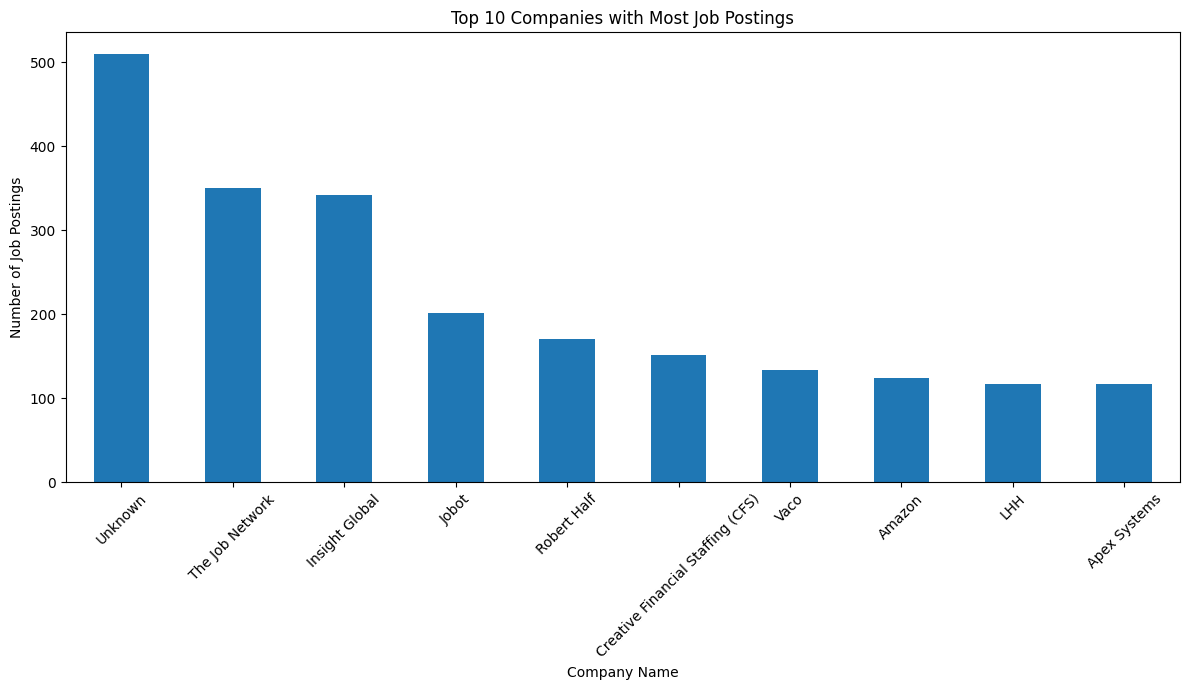

In [1224]:
# Bar chart for the Top 10 companies with the most job listings

top_10_companies = comprehensive_df['company_name'].value_counts().head(10)
# top_10_companies

plt.figure(figsize=(12, 7))
top_10_companies.plot(kind='bar')
plt.title('Top 10 Companies with Most Job Postings')
plt.xlabel('Company Name')
plt.ylabel('Number of Job Postings')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Aside from job postings with "Unknown" companoes, the company with the most job postings is The Job Network, followed by Insight Global, Jobot, and other recruitment firms/agencies and some tech companies. The prevalance of recruitment agenciesa and firms can be explained by how many companies turn to them since it is more time and cost efficient. Small companies may also use these agencies/firms if they do not have a dedicated internal HR or Recruitment team. Larger companies may also use them if they are constantly hiring new personnel or are looking for more qualified candidates.

&nbsp;

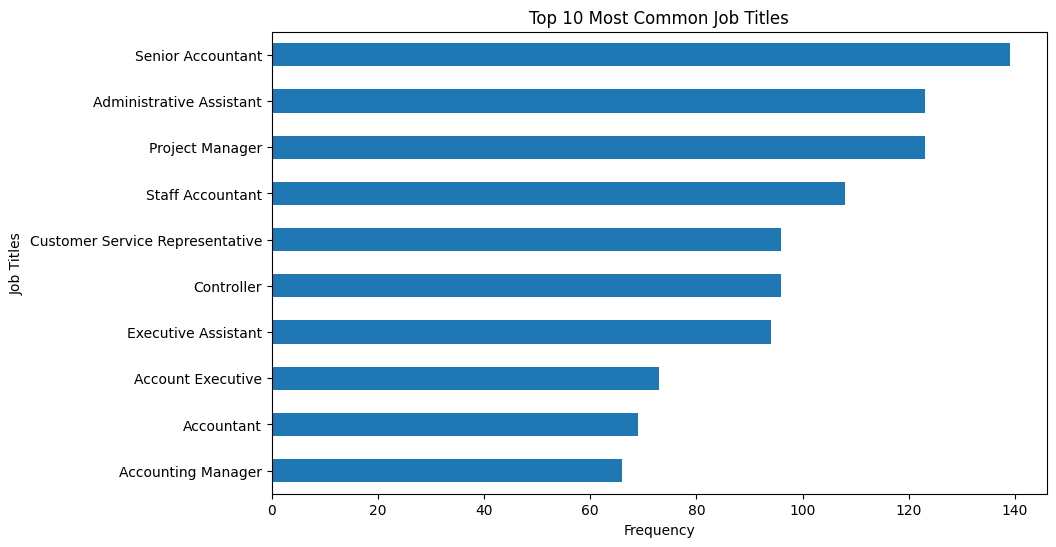

In [1225]:
# Bar chart for the Top 10 most common job titles

job_title_counts = comprehensive_df['title'].value_counts()
job_title_counts

top_job_titles = job_title_counts.head(10)
plt.figure(figsize=(10, 6))
top_job_titles.sort_values().plot(kind='barh')
plt.title('Top 10 Most Common Job Titles')
plt.xlabel('Frequency')
plt.ylabel('Job Titles')
plt.show()

&nbsp;

The most common job titles include "Senior Accountant", "Project Manager", "Administrative Assistant", "Staff Account", and "Controller", with "Senior Accountant" being the most common job title posted. In general, many of the top job postings are in the Accounting Field. This could possibly be due to the job stability associated with the field. Businesses will always need someone to manage their finances, and accountants play an important role in tax preparation and filing.

&nbsp;

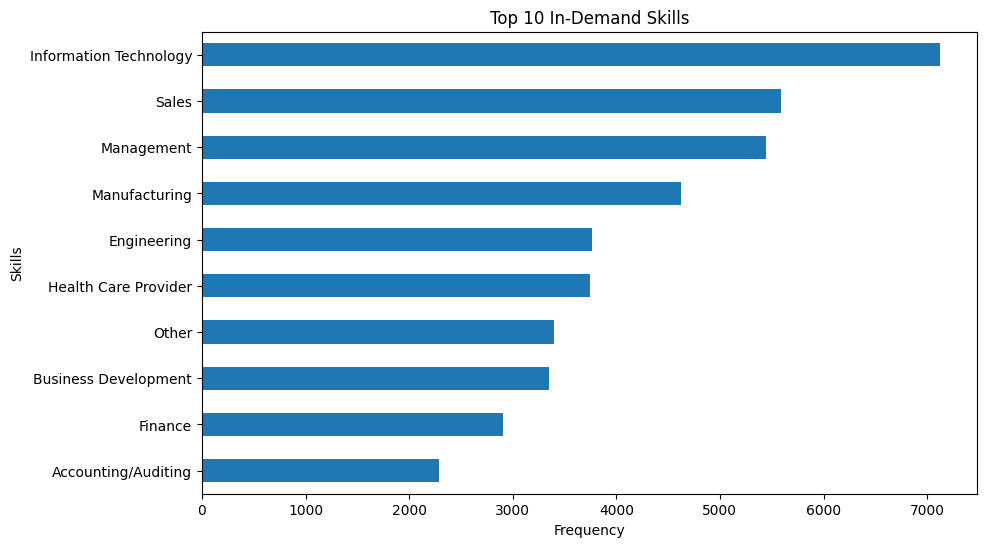

In [1226]:
# Bar chart for the Top 10 most common skills

skills_list = comprehensive_df['skills'].str.split(', ').explode()

# Counting the occurrences of each skill
skills_count = skills_list.str.strip().value_counts()

top_skills = skills_count.head(10)
plt.figure(figsize=(10, 6))
top_skills.sort_values().plot(kind='barh')
plt.title('Top 10 In-Demand Skills')
plt.xlabel('Frequency')
plt.ylabel('Skills')
plt.show()

&nbsp;

"Information Technology" is the most frequently demanded skill, followed by "Sales" and "Management". A factor in this could be the ever growing technologies that pop up in our daily lives. Having solid computer skills allows one to automate their tasks, communicate with colleagues more, analyze data more efficiently, and complete their job in a more productive manner. In the modern workspace they drive innovation, and help one stay more competitive in the rapidly evolving job market.

&nbsp;

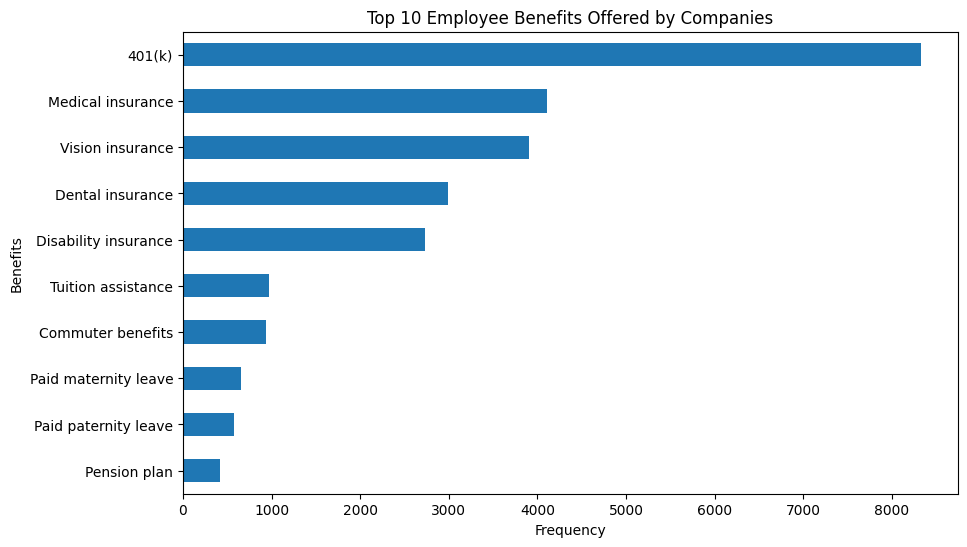

In [1227]:

# Bar chart for the Top 10 most common benefits

benifits_list = comprehensive_df['benefits'].str.split(', ').explode()
benifits_list = benifits_list[benifits_list != 'Unknown']

# Counting the occurrences of each skill
benifits_count = benifits_list.str.strip().value_counts()

top_benefits = benifits_count.head(10)
plt.figure(figsize=(10, 6))
top_benefits.sort_values().plot(kind='barh')
plt.title('Top 10 Employee Benefits Offered by Companies')
plt.xlabel('Frequency')
plt.ylabel('Benefits')
plt.show()

&nbsp;

The most common benefit offered by companies includes a 401(k), with Medical Insurance and Vision Insurance being commonly offered as well. Since saving for retirement can be difficult, having a 401(k) can be important for some people. By having a 401(k) plan, employees can have their contributions automatically deducted from their payroll. Additionally, it also offers tax benefits that some may find valuable. As for Medical and Vision Insurance, having Health (related) insurance through their employer can protect them from unexpected, high medical costs.

&nbsp;

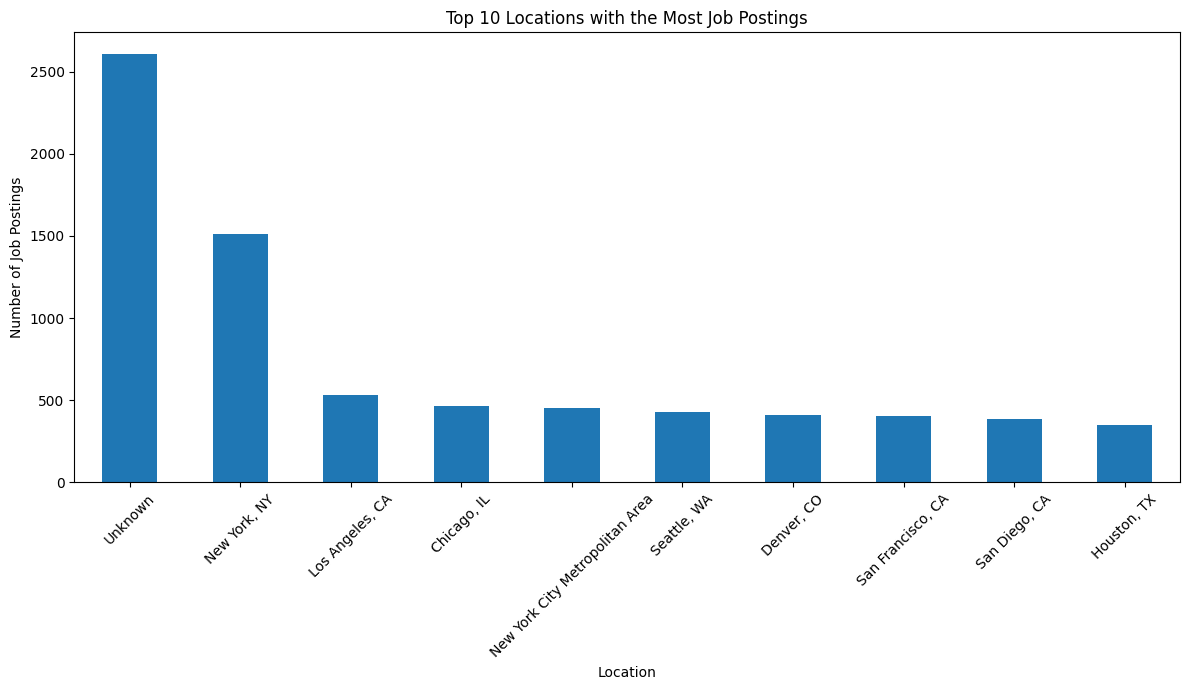

In [1228]:
top_10_locations = comprehensive_df['location'].value_counts().head(10)

plt.figure(figsize=(12, 7))
top_10_locations.plot(kind='bar')
plt.title('Top 10 Locations with the Most Job Postings')
plt.xlabel('Location')
plt.ylabel('Number of Job Postings')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

&nbsp;

Aside from job postings where the location was "Unknown", the location with the highest number of job postings is New York (City), NY. New York City is a major hub for employment, namely for Business/Finance and Technology related fields. Cities like Los Angeles, Chicago, and Seattle are also major employment hubs. Chicago is regularly voted as one of the U.S.'s top cities for grads and has a lower cost of living with relatively high wages compared to other locations. Los Angeles offers vibrant lifestyles and Seattle is also a major tech hub.

&nbsp;

<Figure size 1200x600 with 0 Axes>

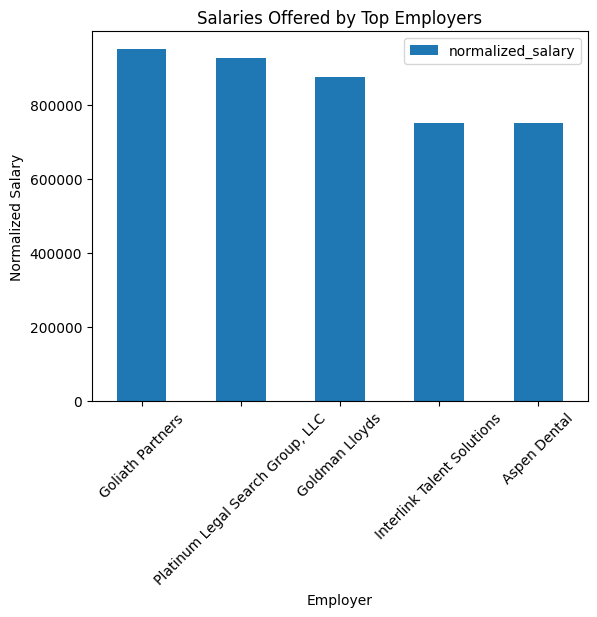

In [ ]:
top_employers = comprehensive_df.sort_values(by='normalized_salary', ascending=False)  # Select top 5 employers, change back to min salary
top_employers.drop_duplicates(subset='company_name', keep='first', inplace=True)
top_employers = top_employers.head(5)  # Select top 5 employers, change back to min salary

# # Visualize average salaries by top employers
plt.figure(figsize=(12, 6))
top_employers.plot(kind='bar', y='normalized_salary', x='company_name')
plt.xlabel('Employer')
plt.ylabel('Normalized Salary')
plt.title('Salaries Offered by Top Employers')
plt.xticks(rotation=45)
plt.show()

&nbsp;

<Figure size 1200x600 with 0 Axes>

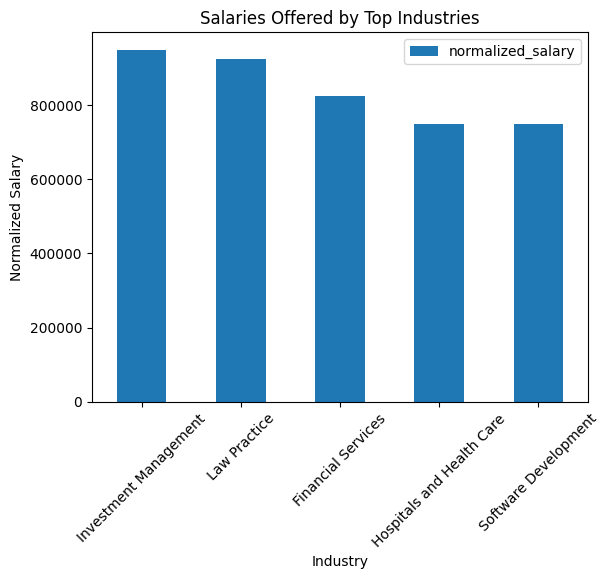

In [1349]:
top_industry_salary = comprehensive_df.sort_values(by='normalized_salary', ascending=False)  # Select top 5 employers, change back to min salary
top_industry_salary.drop_duplicates(subset='industry_name', keep='first', inplace=True)
top_industry_salary = top_industry_salary.head(5)  # Select top 5 employers, change back to min salary

# # Visualize average salaries by top industries
plt.figure(figsize=(12, 6))
top_industry_salary.plot(kind='bar', y='normalized_salary', x='industry_name')
plt.xlabel('Industry')
plt.ylabel('Normalized Salary')
plt.title('Salaries Offered by Top Industries')
plt.xticks(rotation=45)
plt.show()

&nbsp;

The company with the highest average salary is Goliath Partners with law firms such as Platinum Legal Search Group, LLC and other recruitment firms such as Goldman Lloyds and then Aspen Dental following after. From the second chart with the salaries of the top paying industries, we can see that the highest paying industry is Investment Management, followed by Law Practice, Financial Services, Hospitals and Health Care, and Software Development. This aligns with my current knowledge about the job market as I know that these are some of the most popular career fields, this being Law, Technology, and Healthcare.

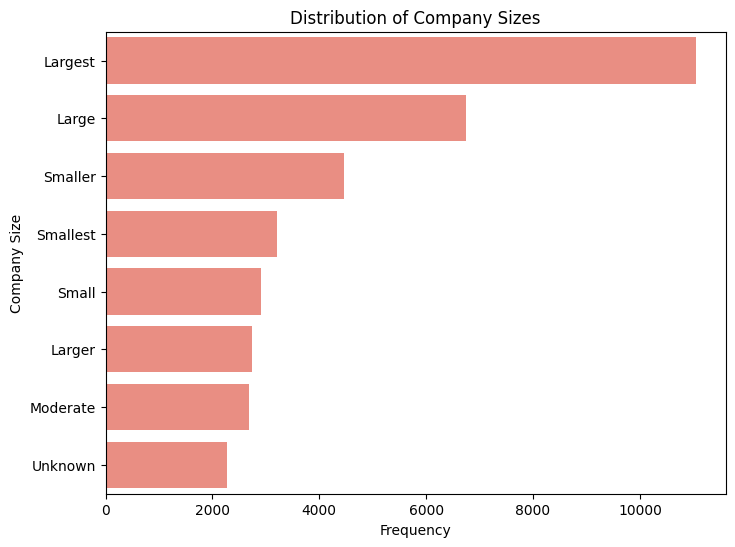

In [1231]:

# Bar chart for the distribution of company sizes (label)

size_labels = {
    -1: 'Unknown',
    1: 'Smallest',
    2: 'Smaller',
    3: 'Small',
    4: 'Moderate',
    5: 'Large',
    6: 'Larger',
    7: 'Largest'
}

df_with_size_label = comprehensive_df.copy()
df_with_size_label['company_size_label'] = df_with_size_label['company_size'].map(size_labels)

# Create a count plot to visualize the distribution of company sizes
plt.figure(figsize=(8, 6))
sns.countplot(y='company_size_label', data=df_with_size_label, order=df_with_size_label['company_size_label'].value_counts().index, color='salmon')
plt.title('Distribution of Company Sizes')
plt.xlabel('Frequency')
plt.ylabel('Company Size')
plt.show()

&nbsp;

The largest companies have the highest number of job postings, followed by those that are large and moderately small. This shows that the largest companies are the primary contributors to the job market from 2023-2024. This may be in part due to the fact that they may be located in major employment hubs and thus may provide more of a variety of employment opportunities.

&nbsp;

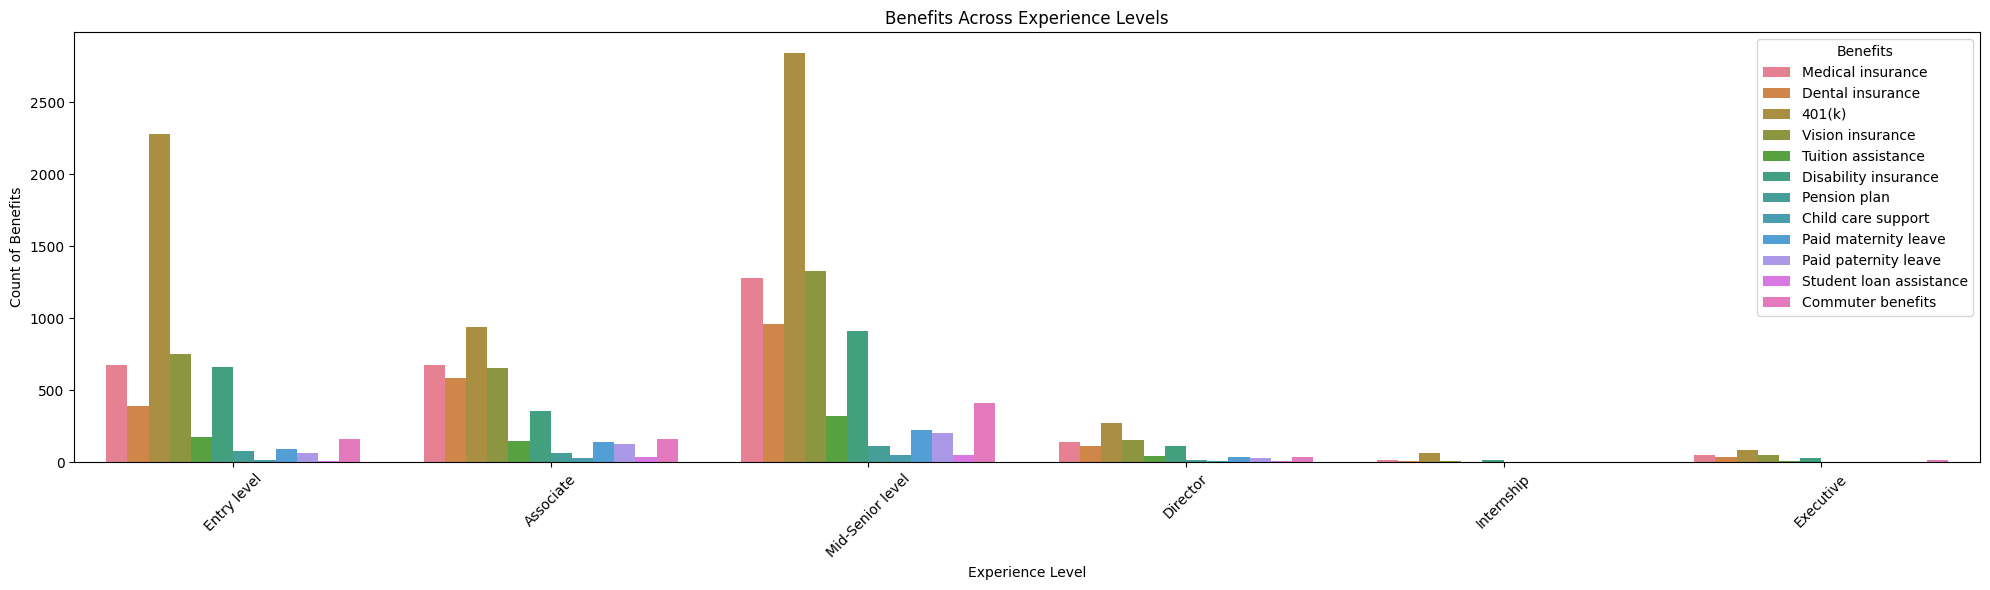

In [1232]:
benefits_exp_df = pd.DataFrame()
benefits_exp_df['experience_level'] = comprehensive_df['formatted_experience_level']
benefits_exp_df = benefits_exp_df.loc[benefits_exp_df['experience_level'] != "Unknown"]
benefits_exp_df['benefits'] = comprehensive_df['benefits'].str.split(', ')

benefits_exp_df = benefits_exp_df.explode('benefits')
benefits_exp_df['benefits'] = benefits_exp_df['benefits'].str.strip()
benefits_exp_df = benefits_exp_df.loc[benefits_exp_df['benefits'] != "Unknown"]

# Count plot to visualize the relationship between benefits and experience levels
plt.figure(figsize=(20, 6))
sns.countplot(x='experience_level', hue='benefits', data=benefits_exp_df)
plt.title('Benefits Across Experience Levels')
plt.xlabel('Experience Level')
plt.ylabel('Count of Benefits')
plt.legend(title='Benefits', loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

&nbsp;

The graph shows that people with Mid-Senior level experience receive the most benefits, which could indicate that companies value offering a variety of benefits and perks to retain experienced professionals. Postings for entry-level and associate jobs follow after which can be explained by how companies tend to hire more entry level and associate level positions for new graduates. There also appears to be less positions with Director and Executive level experience, which can be explained through vertical advancement within companies. Internship positions, since they are not regular full time or part time employees, tend to not include employee benefits.

&nbsp;

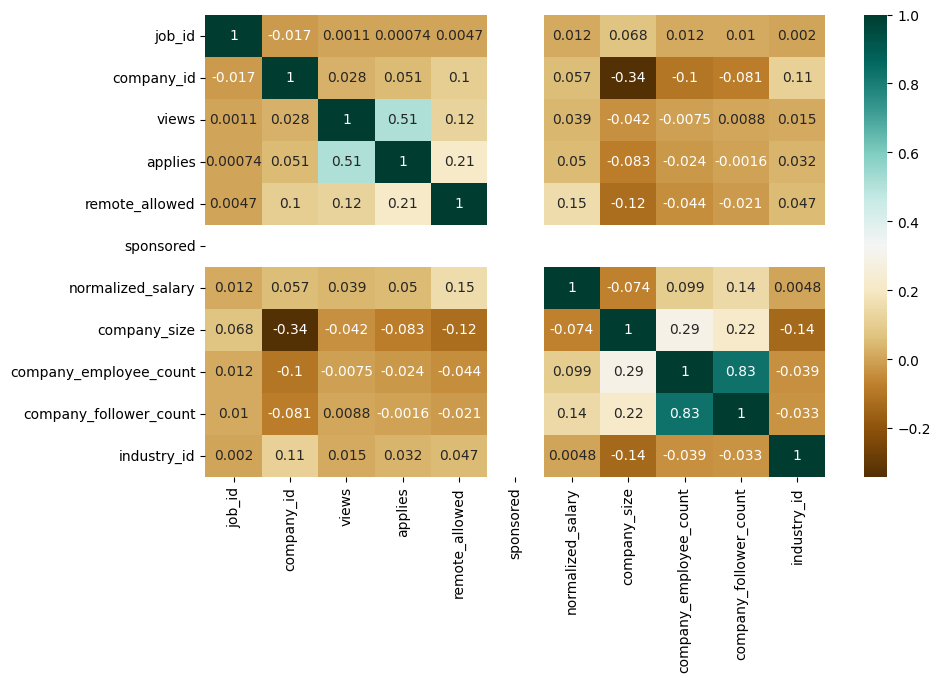

In [1233]:
plt.figure(figsize=(10, 6))
dataplot = sns.heatmap(comprehensive_df.corr(numeric_only=True), cmap="BrBG", annot=True)
plt.show()

&nbsp;

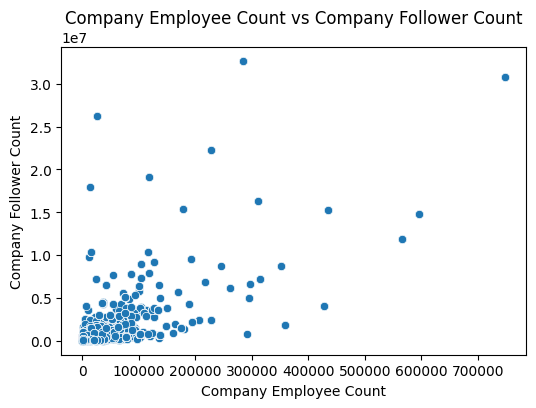

In [1234]:
plt.figure(figsize=(6, 4))
sns.scatterplot(data=comprehensive_df, x='company_employee_count', y='company_follower_count')
plt.title('Company Employee Count vs Company Follower Count')
plt.xlabel('Company Employee Count')
plt.ylabel('Company Follower Count')
plt.show()

&nbsp;

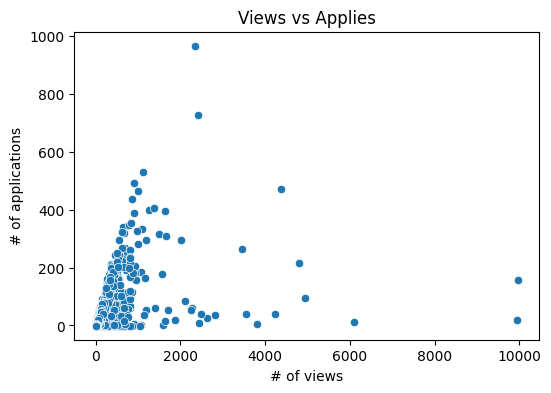

In [1235]:
plt.figure(figsize=(6, 4))
sns.scatterplot(data=comprehensive_df, x='views', y='applies')
plt.title('Views vs Applies')
plt.xlabel('# of views')
plt.ylabel('# of applications')
plt.show()

&nbsp;

There is a moderately strong positive correlation between the numbero of applications and the number of views a job post got. Company Employee Count and Employee Follower Count also appear to be highly positively correlated with a non-linear relationship. There appears to be high outliers visible in both charts, and both do not have a normal or wide distributions, but rather many values are clumped together. 

&nbsp;

## Outlier Detection

&nbsp;

In [1236]:
# One hot encode regions
region_dummies = pd.get_dummies(comprehensive_df['region'], prefix='region', dtype='int')
region_inc_df = pd.concat([comprehensive_df, region_dummies], axis=1)

In [1237]:
# One hot encode industries

industry_dummies = pd.get_dummies(comprehensive_df['industry_name'], prefix='industry', dtype='int')
industry_inc_df = pd.concat([comprehensive_df, industry_dummies], axis=1)

industry_region_dummies = pd.get_dummies(region_inc_df['industry_name'], prefix='industry', dtype='int')
industry_region_df = pd.concat([region_inc_df, industry_region_dummies], axis=1)


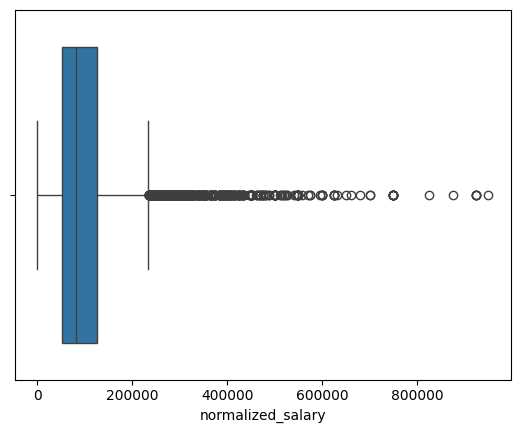

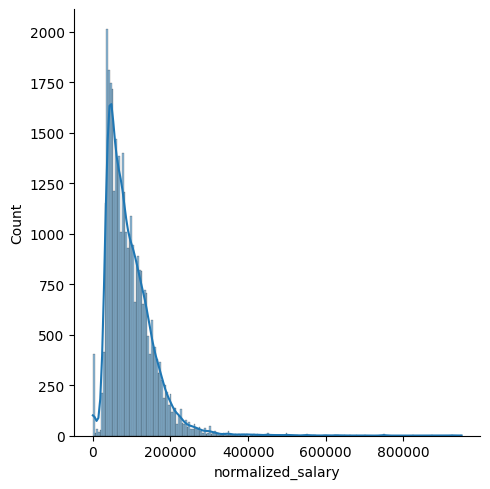

In [1238]:
sns.boxplot(x =comprehensive_df['normalized_salary'])

sns.displot(comprehensive_df['normalized_salary'].to_frame(), x="normalized_salary", kde=True)
plt.show()

In [1306]:
print(comprehensive_df['normalized_salary'].describe())
print("Median:", comprehensive_df['normalized_salary'].median())

count     36072.000000
mean      95415.181661
std       61296.310390
min           0.000000
25%       51875.150000
50%       81120.000000
75%      124800.000000
max      950000.000000
Name: normalized_salary, dtype: float64
Median: 81120.0


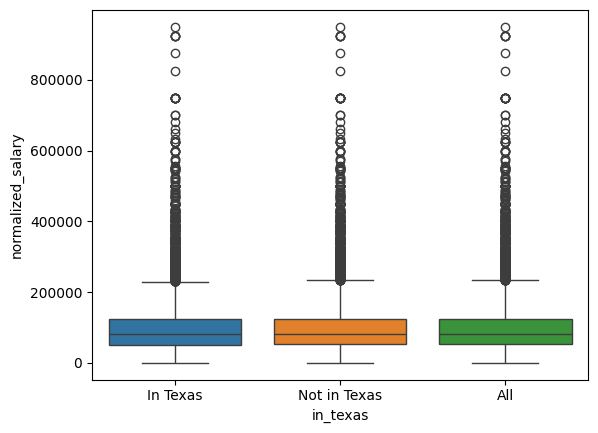

In [1240]:
boxplot_df = region_inc_df.copy()
boxplot_df.loc[boxplot_df['location'].str.contains('TX', case=False, na=False), 'in_texas'] = 1
boxplot_df['in_texas'] = boxplot_df['in_texas'].fillna(0).astype('int64')

isInTexas = boxplot_df.loc[(boxplot_df['in_texas']==1 & boxplot_df['industry_name'].eq('Software Development')), 'normalized_salary']
notInTexas = boxplot_df.loc[(boxplot_df['in_texas']==0 & boxplot_df['industry_name'].eq('Software Development')), 'normalized_salary']
allInstances = boxplot_df['normalized_salary']

# allInstances = boxplot_df.loc[(boxplot_df['normalized_salary'].le(600000)), 'normalized_salary']

boxplot_df = pd.DataFrame({'In Texas': isInTexas, 'Not in Texas': notInTexas, 'All': allInstances})
boxplot_df

plt.gca().ticklabel_format(axis='y', style='plain')

sns.boxplot(data=boxplot_df).set(
    xlabel='in_texas', 
    ylabel='normalized_salary'
)
plt.show()

&nbsp;

In [1241]:
q3_in, q1_in = np.percentile(isInTexas, [75 ,25])
iqr_in = q3_in - q1_in

q3_out, q1_out = np.percentile(notInTexas, [75 ,25])
iqr_out = q3_out - q1_out

q3_all, q1_all = np.percentile(allInstances, [75 ,25])
iqr_all = q3_all - q1_all

pd.Series(isInTexas).describe()
outliers_in = isInTexas.to_frame()[(isInTexas.to_frame()['normalized_salary'] < q1_in - 1.5 * iqr_out) |
                  (isInTexas.to_frame()['normalized_salary'] > q3_in + 1.5 * iqr_in)]

pd.Series(notInTexas).describe()
outliers_out = notInTexas.to_frame()[(isInTexas.to_frame()['normalized_salary'] < q1_out - 1.5 * iqr_out) |
                  (notInTexas.to_frame()['normalized_salary'] > q3_out + 1.5 * iqr_out)]

pd.Series(allInstances).describe()
outliers_all = allInstances.to_frame()[(isInTexas.to_frame()['normalized_salary'] < q1_all - 1.5 * iqr_all) |
                  (allInstances.to_frame()['normalized_salary'] > q3_all+ 1.5 * iqr_all)]

zscores_in = stats.zscore(isInTexas)
zscores_in = zscores_in.to_frame()

zscores_out = stats.zscore(notInTexas)
zscores_out = zscores_out.to_frame()

zscores_all = stats.zscore(allInstances)
zscores_all = zscores_all.to_frame()

z_count_in = len(zscores_in[zscores_in['normalized_salary'].le(-3) | zscores_in['normalized_salary'].ge(3)])
z_count_out = len(zscores_out[zscores_out['normalized_salary'].le(-3) | zscores_out['normalized_salary'].ge(3)])
z_count_all = len(zscores_all[zscores_all['normalized_salary'].le(-3) | zscores_all['normalized_salary'].ge(3)])

print("Outliers in allInstances using IQR:", outliers_all.shape[0])
print("Outliers in allInstances using Z scores:", z_count_all)
print("Outliers in inTexas using IQR:", outliers_in.shape[0])
print("Outliers in inTexas using Z scores:", z_count_in)
print("Outliers in notInTexas using IQR:", outliers_out.shape[0])
print("Outliers in notInTexas using Z scores:", z_count_out)

Outliers in allInstances using IQR: 797
Outliers in allInstances using Z scores: 444
Outliers in inTexas using IQR: 861
Outliers in inTexas using Z scores: 411
Outliers in notInTexas using IQR: 791
Outliers in notInTexas using Z scores: 419


/var/folders/h9/r0t2_hbj4x16z3_qfjbs0npm0000gn/T/ipykernel_56577/17232876.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outliers_out = notInTexas.to_frame()[(isInTexas.to_frame()['normalized_salary'] < q1_out - 1.5 * iqr_out) |


In [1307]:
print("All Instances", allInstances.describe())
print("All Instances Median:", allInstances.median())

print("In Texas", isInTexas.describe())
print("In Texas Median:", isInTexas.median())

print("Not in Texas", notInTexas.describe())
print("Not in Texas Median:", notInTexas.median())


All Instances count     36072.000000
mean      95415.181661
std       61296.310390
min           0.000000
25%       51875.150000
50%       81120.000000
75%      124800.000000
max      950000.000000
Name: normalized_salary, dtype: float64
All Instances Median: 81120.0
In Texas count     32967.000000
mean      94269.451550
std       60707.421816
min           0.000000
25%       51006.800000
50%       80000.000000
75%      122500.000000
max      950000.000000
Name: normalized_salary, dtype: float64
In Texas Median: 80000.0
Not in Texas count     34097.000000
mean      95759.660523
std       61567.487953
min           0.000000
25%       52000.000000
50%       81750.000000
75%      125000.000000
max      950000.000000
Name: normalized_salary, dtype: float64
Not in Texas Median: 81750.0


&nbsp;

For all instances in the dataset, the Normalized Salary ranged between $0 and $950,000, with a lower quartile value of $51,875, a mean value of approximately $95,415, a median value of $81,120, an upper quartile value of approximately $124,800. There appear to be several upper outliers, indicating a wide distribution. Using IQR, there were 797 outliers. Using Z scores, there were 444 outliers.\
\
For job postings in Texas, the Normalized Salary ranged between $0 and $950,000, with a lower quartile value of $51,006, a mean value of approximately $94,269, a median value of $80,000, an upper quartile value of $122,500. There appear to be several upper outliers of values of up to indicating a wide distribution. The data appears to be possibly slightly skewed to the right. Using IQR, there were 861 outliers. Using Z scores, there were 411 outliers.\
\
For job postings not in Texas, the Normalized Salary ranged between $0 and $950,000, with a lower quartile value of $52,000, a mean value of approximately $95,838, a median value of $81,750, an upper quartile value of $125,000. There are to be several upper outliers. The data also appears to be slightly skewed to the right. Using IQR, there were 791 outliers. Using Z scores, there were 419 outliers.\
\
Overall, the median Normalized Salary is highest in instances where job listings were outside of Texas, with the most outliers occuring in Texas job postings using IQR, and outside of Texas using Z Scores.

&nbsp;

## Linear Regression

&nbsp;

In [1308]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X = comprehensive_df.copy()
y = X[['normalized_salary']]
X = X[['company_employee_count', 'company_follower_count']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42) 

linr = LinearRegression()
linr = linRegModel.fit(X_train, y_train)

linr.fit(X_train,y_train)  
y_pred = linr.predict(X_test) 

intercepts = linr.intercept_
coefficients = linr.coef_

feature_names = list(X.columns)
feature_importance = zip(feature_names, coefficients)

mse_linr = metrics.mean_squared_error(y_test, y_pred)
mae_linr = metrics.mean_absolute_error(y_test, y_pred)
r2_linr = metrics.r2_score(y_test, y_pred)

print("Coefficients: \n", coefficients)
print("Intercept: \n", intercepts)
print("Mean squared error: %.2f" % mse_linr)
print("Residual Mean squared error: %.2f" % np.sqrt(mse_linr))
print("Mean absolute error: %.2f" % mae_linr)
print("Coefficient of determination: %.2f" % r2_linr)


Coefficients: 
 [[-0.05615058  0.00409342]]
Intercept: 
 [93144.09713662]
Mean squared error: 3880882487.78
Residual Mean squared error: 62296.73
Mean absolute error: 43944.16
Coefficient of determination: 0.02


In [1244]:
# Predict Normalized Salary when Industry = Software Development, the location is in Texas, and remote is allowed

predict_value = linRegModel.predict([[1200, 30000]])
predict_value

/Users/maddieadair/Documents/COSC 3337 Project/.venv/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([[93199.51908428]])

&nbsp;

Using linear regression to predict Normalized Salary with our independent variables being whether the industry is Software Development, remote is allowed, and it is in Texas, we get a Mean Squared Error of 3880882487.78, RSME value of 62296.73, and a Coefficient of Determination of 0.02 which indicates that the regression model explains only 2% of the variance in Normalized Salary and that the model may not be the best at predicting such.\
\
Using the model, if we were to predict the normalized salary for a job posting the company employee count = 1200 and the company follower count = 30000, we would obtain a salary of approximately $93,200.\
\
Given the coefficients and intercept, our equation for the model is **normalized_salary = -0.05615058(company_employee_count) + 0.00409342(company_follower_count) + 93144.09713662.**

&nbsp;

## Classification

In [1309]:
work_type_dummies = pd.get_dummies(industry_inc_df['formatted_work_type'], prefix='work_type', dtype='int')
experience_dummies = pd.get_dummies(industry_inc_df['formatted_experience_level'], prefix='exp_lvl', dtype='int')
company_size_dummies = pd.get_dummies(industry_inc_df['company_size'], prefix='company_size', dtype='int')

all_df = pd.concat([industry_inc_df, work_type_dummies], axis=1)
all_df = pd.concat([all_df, experience_dummies], axis=1)
all_df = pd.concat([all_df, company_size_dummies], axis=1)
all_df = all_df.drop(['job_id', 'company_id', 'industry_id', 'formatted_work_type', 'formatted_experience_level', 'company_size'], axis=1)

&nbsp;

#### Random Forest

&nbsp;

In [1312]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Create new y variable 'in_texas'
X = all_df.copy()
X.loc[X['location'].str.contains('TX', case=False, na=False), 'in_texas'] = 1
X['in_texas'] = X['in_texas'].fillna(0).astype('int64')

# Use only numeric attributes
y = X['in_texas']
X = X.select_dtypes(include='number')
X = X.drop(['in_texas'], axis=1)
X.columns

param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20),
              'criterion': ['gini', 'entropy']
              }
              
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(random_state = 42)

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, param_distributions = param_dist, n_iter=5, cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)


# y_pred = rf.predict(X_test)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=5,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x344de99d0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x36c19e430>})

`n_estimators` is the number of decision trees in the forest. Increasing this generally improves the performance of the model and also increases the computational cost of the model. `max_depth` is the maximum depth of each decision tree in the forest. A high value of this can lead to overfitting while a lowe value can lead to underfitting. Here we are setting them to a random number between 50 and 500 and a random number between 1 and 20 respectively while we perform cross-validation to determine the best parameters. `criterion` measures the quality of the split.

In [1326]:
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 286}


In [1327]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred)
precision_rf, recall_rf, fscore_rf, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy_rf:.2%}")
print(f"Precision: {precision_rf:.2%}")
print(f"Recall: {recall_rf:.2%}")
print(f"F1-Score: {fscore_rf:.2%}")

Accuracy: 94.14%
Precision: 88.62%
Recall: 94.14%
F1-Score: 91.29%


/Users/maddieadair/Documents/COSC 3337 Project/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


&nbsp;

Running RandomizedSearchCV, we were able to determine that (at the time of running) the best max_depth for the random forest was 10, with the best n_estimators being 286.\
\
Running the Random Forest algorithm again with these parameters (the best max_depth, n_estimators, and criterion), we obtained an accuracy of 94.14%, precision of 88.62%, a recall score of 94.14% and an F1 Score of 91.29%.

&nbsp;

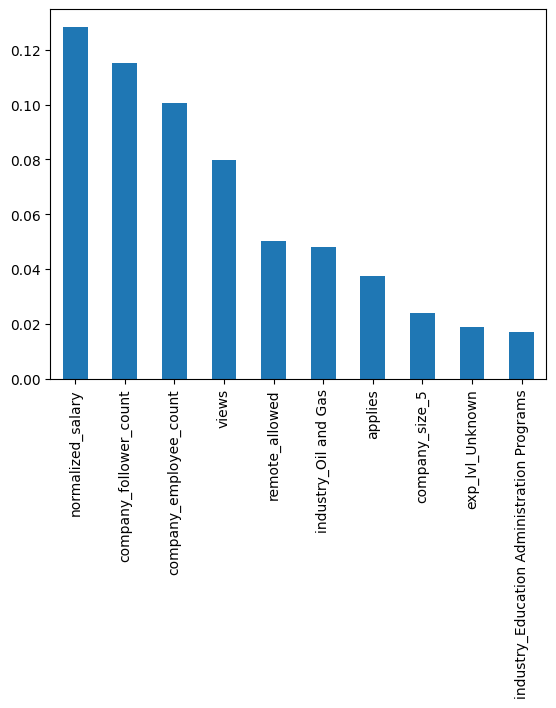

In [1330]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(10)

# Plot a simple bar chart
feature_importances.plot.bar();

&nbsp;

The feature importance chart shows us that the biggest predictor of whether a job posting was in Texas is Normalized Salary, with Company Follower Count and Company Employee Count following right after. Other important features include the number of applications the job posting received, the number of views the job post received, whether remote work is allowed or not, and whether the industry is in Oil and Gas, This would make sense, since Texas is a major hub for the oil and gas industry.

&nbsp;

#### KNN

&nbsp;

Text(0, 0.5, 'Accuracy Score')

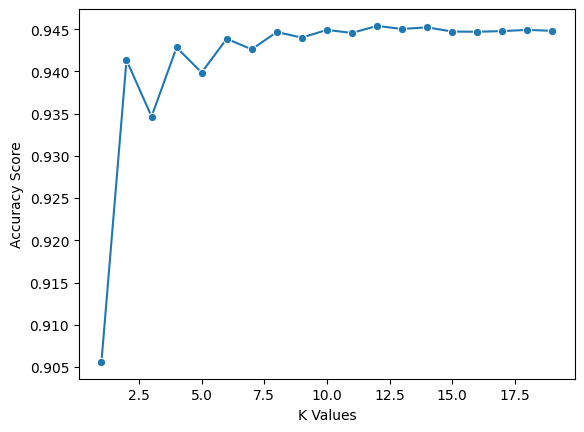

In [1292]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

k_values = [i for i in range (1,20)]
scores = []

scaler = StandardScaler()
X = scaler.fit_transform(X)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X, y, cv=5)
    scores.append(np.mean(score))

sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

&nbsp;

In [1294]:
best_k = np.argmax(scores)
print("Best k:", k)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)

#train model with cv of 5 
cv_scores_knn= cross_val_score(knn, X, y, cv=5)
#print each cv score (accuracy) and average them
print(cv_scores_knn)
print(f'cv_scores mean: {np.mean(cv_scores_knn):.2%}')


y_pred = knn.predict(X_test)

precision_knn, recall_knn, fscore_knn, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
accuracy_knn = metrics.accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy_knn:.2%}")
print(f"Precision: {precision:.2%}")
print(f"Recall: {recall:.2%}")
print(f"F1-Score: {fscore:.2%}")

Best k: 19
[0.94511435 0.94303534 0.94427502 0.94496812 0.94538398]
cv_scores mean: 94.46%
Accuracy: 94.19%
Precision: 93.59%
Recall: 94.80%
F1-Score: 92.57%


&nbsp;

After implementing cross validation, with the number of splits set to 5, we find that the best k value is 19. We then perform KNN again with k = 19 and get an accuracy score of 94.19%, precision score of 93.59%, recall score of 94.80%, an F1 Score of 92.57%, and a mean cv score of 94.46%.

&nbsp;

### Conclusion

&nbsp;

In [1331]:
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score'],
    'KNN': [accuracy_knn, precision_knn, recall_knn, fscore_knn],
    'Random Forest': [accuracy_rf, precision_rf, recall_rf, fscore_rf],
})

metrics_df

,Metric,KNN,Random Forest
0,Accuracy,0.941927,0.941372
1,Precision,0.921273,0.886182
2,Recall,0.941927,0.941372
3,F1-score,0.917787,0.912943


&nbsp;

In conclusion, in terms of classification performance, while all models did well, KNN performed marginally better than Random Forest. However, this metric is relatively insignificant as the difference in accuracy between these two models is 0.0555%.\
\
The advantages that KNN has over the Random Forests is that it has few parameters to tune, it doesn't require linear scalability and makes no assumption about the distribution of the data as it is non-parametric. While this makes the model more flexible, having too low of a k value can lead to overfitting of the training data and too high of a k value can lead to the neighborhood may include points from other classes. However, compared to the other models you are unable to decide which features are most important and to be more accurate it needs more data.\
\
Advantages of Random Forests include high accuracy, that it estimates feature importance, is non-parametric in nature, and handles outliers well. However it is prone to overfitting when the model captures noise in the training data, leading to overfitting. Additionally it is computationally expensive and may lack interpretability.\
\
Linear Regression did not work well, and produced a low R squared value and large MSE, RMSE, and MAE value, suggesting that the independent variables in the model were very weak at explaining the variance in normalized salary. To improve this next time, model specifications could be refined while considering non-linear relationships between variables.\
\
Through EDA we learned that the most in demand positions are in the accounting field with 'Senior Accountant' being the most listed job title on LinkedIn. We also learned that the skills that are in high demand include "Information Technology", "Sales" and "Management", and that the top benefit offered by employers is a 401(k), with positions with mid-senior level experience receiving the most benefits, followed by entry-level and associate positions. It was also revealed that the top location for job postings is in New York (City), which could be due to how New York (City) is one of the major cities in the country and is a center for multiple different industries. Salary wise, it was shown that the companies that offered the highest normalized salaries were within the Legal, Recruiting, and Technology fields.\
\
Through heatmaps and scatterplots, we learned that there was a moderate positive correlation between the number of views a job post and the number of applications a job post received, as well as a strong positive correlation between the number of employees in a company and the number of followers that company has. Both relationships are non-linear.\
\
Finally through classification, we learned that some of the most important features in predicting whether a job posting will be in Texas is the job's normalized salary, the number of views the job post received, how many employees and followers the company has, as well as other factors relating to experience level and whether the job is within the Oil and Gas industry.